# QAOA for the Max-Cut using Fire Opal

The Max-Cut problem is a canonical NP-hard problem in combinatorial optimization. Formally, given a weighted, undirected graph $G=(V,E,w)$, the task is to partition the vertex set into two disjoint groups such that the number (or weight) of edges crossing the partition is maximized. Given a weighted, undirected graph $G=(V,E,w)$, Max-Cut asks for a bipartition $V=A\cup B$ that maximizes the total weight of edges that cross the cut:

$$
\max_{A,B}\ \sum_{(i,j)\in E} w_{ij}\,[\![i\in A,\ j\in B]\!].
$$

With spin variables $s_i\in\{-1,+1\}$ (two colors), the objective can be written

$$
\max_{s\in\{\pm1\}^{|V|}} \sum_{(i,j)\in E} \frac{w_{ij}}{2}\bigl(1 - s_i s_j\bigr),
$$

which leads directly to the standard Ising form used in quantum algorithms:

$$
H_{\text{cut}} \;=\; \sum_{(i,j)\in E} \frac{w_{ij}}{2}\left(I - Z_i Z_j\right).
$$

Minimizing $\langle H_{\text{cut}}\rangle$ is equivalent to maximizing the cut.

## 1. Problem Definition

In this section, we build a triangular lattice with $L=5$ levels, yielding $N=15$ nodes. The nodes are arranged in rows of increasing size: $1,2,3,4,5$. Each node connects to its immediate neighbors:

* **In-row neighbors**: horizontal connections.
* **Down-left and down-right neighbors**: diagonal connections to the next row.

This produces a non-bipartit structure with 30 edges, ideal for texting Max-Cut.

In [1]:
import jijmodeling as jm
import ommx.v1
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from functools import reduce

import networkx as nx
from IPython.display import display, Latex
from functools import reduce

import qamomile.core as qm
import qamomile.qiskit as qm_qk

import qiskit.primitives as qk_pr
from scipy.optimize import minimize
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2

import fireopal as fo
from qiskit import QuantumCircuit
from qiskit import qasm3
from fireopal.types import PauliOperator
from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
from pyscipopt import Model
import qctrlvisualizer as qv

from qiskit_ibm_runtime.fake_provider import FakeMumbaiV2
backend = FakeMumbaiV2()

if not hasattr(np, "alltrue"):
    np.alltrue = np.all

### 1.1 Creating the graph

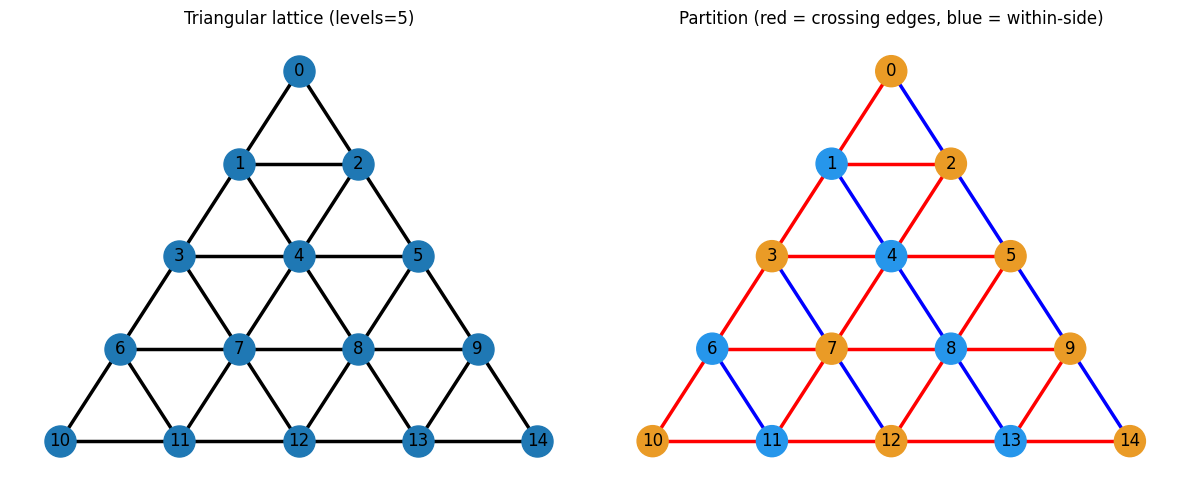

In [2]:
levels = 5
num_nodes = levels * (levels + 1) // 2
G = nx.Graph()
G.add_nodes_from(range(levels * (levels + 1) // 2))
def tri_idx(r: int, c: int) -> int:
    return r * (r + 1) // 2 + c

edges = []
for r in range(levels):
    for c in range(r + 1):
        u = tri_idx(r, c)
        # horizontal within the row
        if c + 1 <= r:
            edges.append((u, tri_idx(r, c + 1)))
        # down-left
        if r + 1 < levels:
            edges.append((u, tri_idx(r + 1, c)))
            # down-right
            edges.append((u, tri_idx(r + 1, c + 1)))
G.add_edges_from(edges)

pos = {}
for r in range(levels):
    y = (levels - 1) - r  # apex at top
    for c in range(r + 1):
        x = c - r / 2.0    # center each row
        pos[tri_idx(r, c)] = (x, y)

# Defining the theoretical max-cut solution for illustration purposes only
cut_solution = {}
for r in range(levels):
    for c in range(r + 1):
        n = tri_idx(r, c)
        cut_solution[(n,)] = 1.0 if ((r + c) % 2 == 1) else 0.0

def get_edge_colors(graph, cut_solution, in_cut_color="r", not_in_cut_color="b"):
    def unbox(k):
        return k[0] if isinstance(k, tuple) and len(k) == 1 else k
    cut_set_1 = {unbox(n) for n, v in cut_solution.items() if bool(v)}
    edge_colors = [
        (in_cut_color if ((u in cut_set_1) ^ (v in cut_set_1)) else not_in_cut_color)
        for u, v in graph.edges()
    ]
    node_colors = ["#2696EB" if n in cut_set_1 else "#EA9B26" for n in graph.nodes()]
    return edge_colors, node_colors
edge_colors, node_colors = get_edge_colors(G, cut_solution)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title(f"Triangular lattice (levels={levels})")
nx.draw_networkx(G, pos, ax=axes[0], node_size=500, width=2.5, with_labels=True)
axes[0].axis("off")
axes[1].set_title("Partition (red = crossing edges, blue = within-side)")
nx.draw_networkx(
    G, pos, ax=axes[1],
    node_size=500, width=2.5, with_labels=True,
    edge_color=edge_colors, node_color=node_colors
)
axes[1].axis("off")
plt.tight_layout()
plt.show()

### 1.2 Constructing the Mathematical Model

As mentioned before, the Max-Cut problem can be formulated with the following equation:

$$
  \max \quad \frac{1}{2} \sum_{(i,j) \in E} (1 - s_i s_j)  
$$

Note that this equation is expressed using Ising variables $ s \in \{ +1, -1 \} $. In this case, we want to formulate it using the binary variables $ x \in \{ 0, 1 \} $ from JijModeling. Therefore, we perform the conversion between Ising variables and binary variables using the following equations:

$$
    x_i = \frac{1 + s_i}{2} \quad \Rightarrow \quad s_i = 2x_i - 1
$$


In [3]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

### 1.3 Preparing Instance Data

Next, we will solve the Max-Cut Problem for the defined graph. The data for the specific problem being solved is referred to as instance data.

In [4]:
V = num_nodes
E = edges
data = {"V": V, "E": E}

### 1.4 Creating a Compiled Instance
We perform compilation using `JijModeling.Interpreter` and `ommx.Instance` by providing the formulation and the instance data prepared earlier. This process yields an intermediate representation of the problem with the instance data substituted.

In [5]:
interpreter = jm.Interpreter(data)
compiled_model = interpreter.eval_problem(problem)

### 1.5 Converting Compiled Instance to QAOA Circuit and Hamiltonian
We generate the QAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.qaoa.QAOAConverter`.

By creating an instance of this class and using `ising_encode`, you can internally generate the Ising Hamiltonian from the compiled Instance. Parameters that arise during the conversion to QUBO can also be set here. If not set, default values are used.

Once the Ising Hamiltonian is generated, you can generate the QAOA quantum circuit and the Hamiltonian respectively. These can be executed using the `get_qaoa_ansatz` and `get_cost_hamiltonian` methods. The number of QAOA layers, $p$, is fixed to be $7$ here.  

In [6]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)
qaoa_converter.ising_encode()
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
p = 7
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

### 1.6 Visualization of QAOA Circuit
Qamomile provides a method to visualize the quantum circuit. You can use the plot_quantum_circuit function to visualize the QAOA quantum circuit.

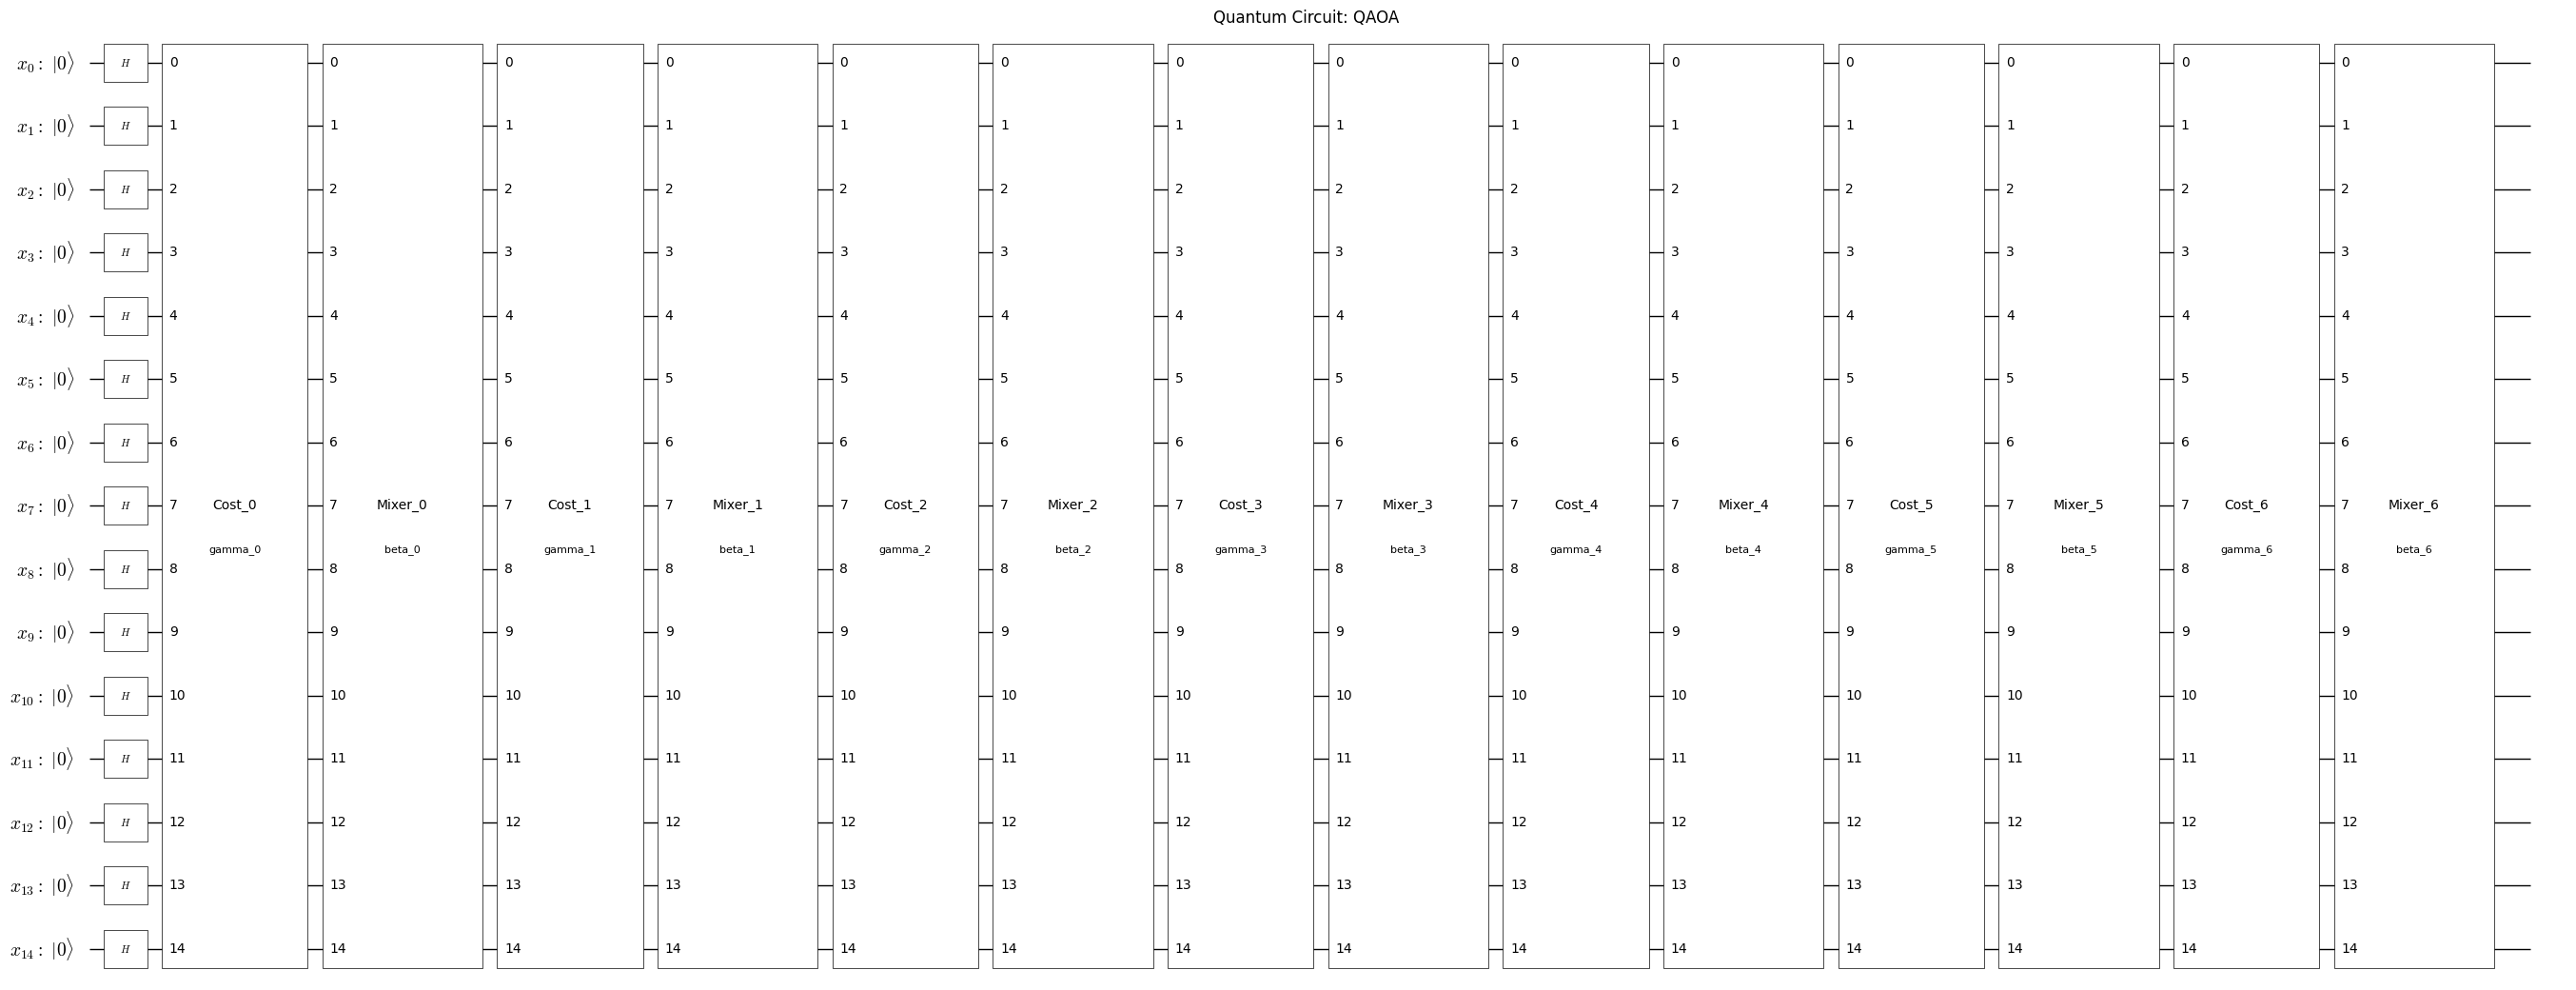

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit
plot_quantum_circuit(qaoa_circuit)

### 1.7 Converting the Obtained QAOA Circuit and Hamiltonian for Qiskit
Here, we generate the Qiskit’s QAOA circuit and Hamiltonian using the `qamomile.qiskit.QiskitTranspiler` converters. By utilizing the two methods,`QiskitTranspiler.transpile_circuit` and `QiskitTranspiler.transpile_hamiltonian`, we can transform the QAOA circuit and Hamiltonian into a format compatible with Qiskit. This allows us to leverage Qiskit’s quantum computing framework to execute and analyze.

In [8]:
qk_transpiler = qm_qk.QiskitTranspiler()
# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_circuit.measure_all()
# Transpile the QAOA Hamitltonian to Qiskit
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZZI', 'IIIIIIIIIIIZIZI', 'IIIIIIIIIIZIIZI', 'IIIIIIIIIIZIZII', 'IIIIIIIIIZIIZII', 'IIIIIIIIIIZZIII', 'IIIIIIIIZIIZIII', 'IIIIIIIZIIIZIII', 'IIIIIIIIIZZIIII', 'IIIIIIIZIIZIIII', 'IIIIIIZIIIZIIII', 'IIIIIIZIIZIIIII', 'IIIIIZIIIZIIIII', 'IIIIIIIZZIIIIII', 'IIIIZIIIZIIIIII', 'IIIZIIIIZIIIIII', 'IIIIIIZZIIIIIII', 'IIIZIIIZIIIIIII', 'IIZIIIIZIIIIIII', 'IIIIIZZIIIIIIII', 'IIZIIIZIIIIIIII', 'IZIIIIZIIIIIIII', 'IZIIIZIIIIIIIII', 'ZIIIIZIIIIIIIII', 'IIIZZIIIIIIIIII', 'IIZZIIIIIIIIIII', 'IZZIIIIIIIIIIII', 'ZZIIIIIIIIIIIII', 'IIIIIIIIIIIIIII'],
              coeffs=[  0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,   0.5+0.j,
 -15. +0.j])

## 2. MaxCut Results without Fire Opal

This section presents the outcomes obtained using Qamomile without Fire Opal optimization. The results serve as a baseline for comparison, highlighting performance when circuits are executed without additional noise-mitigation strategies.  


### 2.1 Probability Conversion and Expectation Evaluation

This code converts measurement outcomes into a probability list over computational basis states and uses them to evaluate the expectation value $\langle H \rangle$ for a Hamiltonian defined in Pauli-Z/I form.  

In [9]:
def convert_probabilities_to_list(probabilities, nqubits,shots):
    """
    Transforms a dictionary of measured probabilities to a list of
    probabilities in the computational basis.
    """
    probs = []
    for key in range(2**nqubits):
        binary_key = format(key, "b").zfill(nqubits)
        probs.append(probabilities.get(binary_key, 0)/shots)
    return probs

def calculate_expectation(measured_probs, hamiltonian=qk_hamiltonian.to_list()):
    """
    Compute expectation value ⟨H⟩ 
    """
    pauli_lengths = {len(p) for p, _ in hamiltonian}
    n = pauli_lengths.pop()

    probs = np.asarray(measured_probs, dtype=float).ravel()
    total = probs.sum()
    probs = probs / total

    # eigenvalues for a Z/I-only Pauli string via Kronecker products
    def eigenvalues_from_pauli(pstr):
        vec_map = {"I": np.array([1.0, 1.0]), "Z": np.array([1.0, -1.0])}
        return reduce(np.kron, (vec_map[c] for c in pstr))

    eigen_cache = {}
    expectation = 0.0
    for pstr, coeff in hamiltonian:
        c = float(np.real(coeff))
        if pstr == "I" * n:
            expectation += c * 1.0
            continue
        if pstr not in eigen_cache:
            eigen_cache[pstr] = eigenvalues_from_pauli(pstr)
        ev = eigen_cache[pstr]
        expectation += c * float(np.dot(ev, probs))

    return expectation


### 2.2 QAOA Optimization

Now we define the QAOA cost function using measured expectation values and optimizes it through a classical optimizer. A parameterized quantum circuit is transpiled and executed on the selected backend. The measurement outcomes are converted into probability distributions, which are then used to evaluate the expectation value $\langle H \rangle$. A COBYLA optimizer minimizes this cost function, while the optimization trajectory is stored in `cost_history` for later analysis.  

In [ ]:
num_shots = 2048
cost_history = []
estimator = qk_pr.StatevectorEstimator()
backend = FakeMumbaiV2()

def estimate_cost(parameters):
        parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, parameters)}
        qc = qk_circuit.assign_parameters(parameters_dict)
        transpiled_circuit = transpile(qc, backend)
        job = backend.run(transpiled_circuit, shots=num_shots)
        counts = job.result().get_counts()
        measured_probs = convert_probabilities_to_list(counts, qc.num_qubits,num_shots)
        expectation_value = calculate_expectation(measured_probs)
        cost_history.append(expectation_value)
        return expectation_value

# Create initial parameters
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# Run QAOA optimization
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 1000, "tol":0.01},
)

### 2.3 Result Visualization
By repeating the optimization, we can observe that the energy decreases and converges.

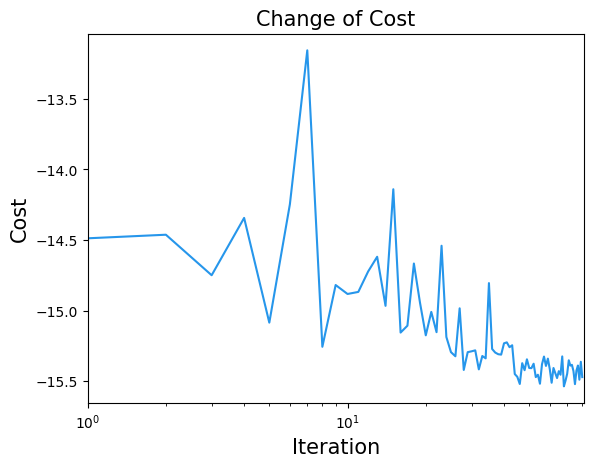

In [11]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Now, let's run the Optimized paremeter on qiskit.

In [ ]:
# Run Optimized QAOA circuit
sampler = SamplerV2(backend)
qc = qk_circuit.assign_parameters(result.x)
transpiled_circuit = transpile(qc, backend)
job = sampler.run([transpiled_circuit], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data.meas.get_counts()

### 2.4 Evaluating the Results
From the job counts obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

In [55]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
energies_qamomile = []
frequencies_qamomile = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq_qamomile = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq_qamomile[sample.objective] += 1
norm = max(energy_freq_qamomile.values())
energies_qamomile = list(energy_freq_qamomile.keys())
frequencies_qamomile = [item / norm for item in list(energy_freq_qamomile.values())]

## 3. MaxCut Results with Fire Opal

This section presents the outcomes obtained using Qamomile with Fire Opal optimization. The results demonstrate the improvements achieved, providing a direct comparison against the baseline execution without Fire Opal.  

### 3.1 Set up your Fire Opal account and choose a backend

To run this section, you will need an [IBM Quantum account](https://quantum.cloud.ibm.com/). Set up your IBM account information to choose a backend.

In [ ]:
token = "YOUR_IBM_CLOUD_API_KEY"
instance = "YOUR_IBM_CRN"

credentials = fo.credentials.make_credentials_for_ibm_cloud(
    token=token, instance=instance
)

Q-CTRL authentication successful!


In [15]:
shot_count = 2048
backend = FakeMumbaiV2()
backend_name = backend.name

### 3.2 Prepare the circuit and Hamiltonian for Fire Opal

In [16]:
# Obtain a list of PauliOperators from the Qiskit Hamiltonian
hamiltonian = qk_hamiltonian.to_list()
# Convert to OpenQASM3
qasm_circ = qasm3.dumps(qk_circuit.decompose())

### 3.3 QAOA Optimization
Since Fire Opal provides a built-in method to calculate expectation values directly from QASM circuits, we can define the QAOA objective function in a straightforward way by mapping parameters to the circuit and passing them to the `estimate_expectation` routine.  


In [ ]:

expectation_value_history = []
trab = []

def objective_function(parameters):
    """
    Calculates the cost based on the quantum circuit's outcome.
    Maps numerical parameters to the circuit parameters, runs the circuit, and computes the expectation value.
    """
    # Map the parameters to the circuit parameters
    parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, parameters)}
    observables = PauliOperator.from_list(hamiltonian)
    job = fo.estimate_expectation(
        circuits=[qasm_circ],
        shot_count=shot_count,
        credentials=credentials,
        backend_name=backend_name,
        parameters=[parameters_dict],
        observables=observables,
    )
    expectation_value = job.result()["expectation_values"][0]

    # Save the intermediate cost values without additional calls to this objective function
    global expectation_value_history
    expectation_value_history.append(expectation_value)

    return expectation_value

# Set options to limit max iterations
options = {"maxiter": 1000, "disp": True}
init_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)
# Minimize the objective function using COBYLA method
result = minimize(
    objective_function, init_params, method="COBYLA", tol=0.01, options=options
)

### 3.4 Result Visualization
By repeating the optimization, we can observe that the energy decreases and converges.

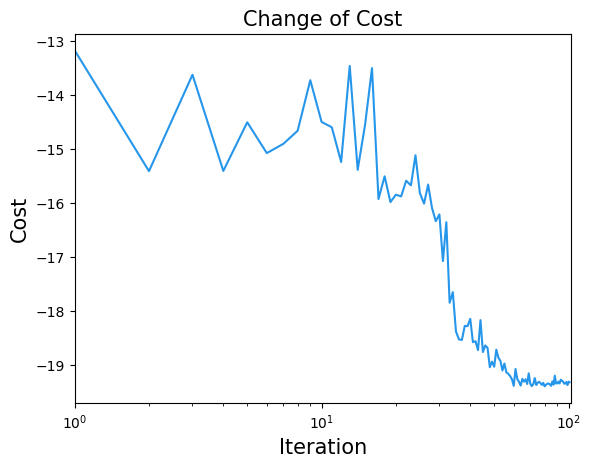

In [18]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(expectation_value_history, label="Cost", color="#2696EB")
plt.show()

### 3.5 Evaluating the Results

Now, let's run the Optimized paremeter on qiskit using Fire Opal.

In [19]:
# Run Optimized QAOA circuit
shot_count=10000
parameters_dict = {param.name: val for param, val in zip(qk_circuit.parameters, result.x)}
job = fo.execute(
    circuits=[qasm_circ],
    parameters=[parameters_dict],
    credentials=credentials,
    backend_name=backend_name,
    shot_count=shot_count,
)

The functions below are used to construct the Max-Cut problem instances and to evaluate the corresponding results

In [52]:
def maxcut_obj(bitstring: str, graph: nx.Graph) -> float:
    """
    Given a bitstring, this function returns the number of edges
    shared between the two partitions of the graph.
    """
    obj = 0
    # Iterate through each edge in the graph
    for i, j, data in graph.edges(data=True):
        # Calculate the contribution of the edge to the Max-Cut objective
        # If the nodes are in different partitions, the term (int(bitstring[i]) - int(bitstring[j]))**2 will be 1
        # Otherwise, it will be 0
        obj -= data.get("weight", 1) * (int(bitstring[i]) - int(bitstring[j])) ** 2
    return obj

def get_cost_distribution(
    distribution: dict[str, int], graph: nx.Graph
) -> tuple[np.ndarray, np.ndarray]:
    """
    Given a bitstring count distribution and a graph, returns the
    costs and relative probabilities as numpy arrays.
    """
    # Total number of bitstrings (shots)
    norm = max(distribution.values())
    costs = []
    probabilities = []
    # Calculate the cost and probability for each bitstring
    for bitstring, count in distribution.items():
        # Reverse the bitstring to match graph node indices
        cost = -maxcut_obj(bitstring[::-1], graph)
        costs.append(cost)
        probabilities.append(count/norm)
    return np.array(costs), np.array(probabilities)


In [ ]:
results = job.result()["results"][0]
fire_opal_counts = {
    bitstring: int(probability * 10000)
    for bitstring, probability in results.items() 
    if int(probability * 10000) > 0
}
energies_fo, frequencies_fo = get_cost_distribution(fire_opal_counts, G)

## 4. Frequency Distribution: With vs Without Fire Opal

The following plot compares the normalized frequency distribution of measurement outcomes at different energy levels when running circuits with and without Fire Opal optimization. Bars are grouped side by side for each energy value: the left bar shows results using Fire Opal, while the right bar shows the baseline execution without Fire Opal. This visualization highlights the relative differences in how noise mitigation affects sampling across energy states.

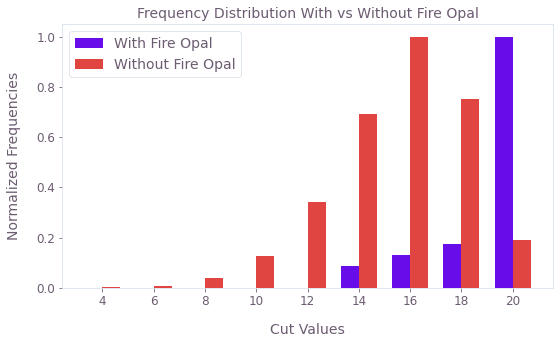

In [ ]:
def group_max(energies, freqs):
    """Return dict: energy -> max(freq) using exact float keys."""
    d = {}
    for e, f in zip(energies, freqs):
        e = float(e); f = float(f)
        if e in d:
            if f > d[e]:
                d[e] = f
        else:
            d[e] = f
    return d

res_fo = group_max(energies_fo, frequencies_fo)
res_qa = group_max(energies_qamomile, frequencies_qamomile)

all_E = sorted(set(res_fo) | set(res_qa))
y_fo = [res_fo.get(e, 0.0) for e in all_E]
y_qa = [res_qa.get(e, 0.0) for e in all_E]

# 3) Plot
bar_width = 0.35
x = np.arange(len(all_E))

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - bar_width/2, y_fo, bar_width, label="With Fire Opal")
ax.bar(x + bar_width/2, y_qa, bar_width, label="Without Fire Opal")

ax.set_xlabel("Cut Values")
ax.set_ylabel("Normalized Frequencies")
ax.set_title("Frequency Distribution With vs Without Fire Opal")

def fmt_energy(e):
    return str(int(e)) if float(e).is_integer() else f"{e:.6g}"

ax.set_xticks(x)
ax.set_xticklabels([fmt_energy(e) for e in all_E], rotation=0)
ax.legend()
ax.set_ylim(0, 1.05 * max(max(y_fo + y_qa), 1.0))  # headroom
plt.tight_layout()
plt.show()

## 5. Solve MaxCut with Fire Opal's `solve_qaoa`

Fire Opal's built-in Quantum Approximate Optimization Algorithm (QAOA) solver can deliver solutions to nontrivial unweighted and weighted graph Max-Cut problems instances using quantum hardware.

### 5.1 Define helper functions

The functions below are used to construct the Max-Cut problem instances and to evaluate the corresponding results

In [ ]:
def generate_random_bitstrings(length, num_bitstrings, rng_seed=0) -> list[str]:
    """
    Generate a random sampling of bitstrings.
    """
    # Initialize the random number generator with a seed for reproducibility
    rng = np.random.default_rng(seed=rng_seed)
    # Generate random bitstrings
    random_array = rng.integers(0, 2, size=(num_bitstrings, length))
    bitstrings = ["".join(row.astype(str)) for row in random_array]
    return bitstrings


def calculate_percent_gap_to_optimal(
    costs: np.ndarray, optimal_cut_value: float
) -> None:
    """
    Determine the percent gap between the optimal cut value and the best cut value
    found from Fire Opal.
    """
    # Find the best cut value found (most negative cost)
    best_cut_value_found = max(-costs)
    # Calculate the percentage difference from the optimal value
    percent_optimality = np.round(
        100 - (abs(optimal_cut_value - best_cut_value_found) / optimal_cut_value * 100),
        2,
    )
    # Print the results
    print(
        f"The best cut value found by Fire Opal is {best_cut_value_found}. \n"
        f"This solution is {percent_optimality}% optimized relative to the classically determined solution, {optimal_cut_value}."
    )


def analyze_maxcut_results(
    distribution: dict[str, int], graph: nx.Graph, optimal_cut_value: float
) -> None:
    """
    Analyze results from Max-Cut execution.
    """
    # Number of nodes in the graph
    qubit_count = graph.number_of_nodes()
    # Total number of bitstrings (shots)
    shot_count = sum(distribution.values())

    # Get cost distribution from the results
    costs, probs = get_cost_distribution(distribution, graph)
    # Generate random bitstrings and get their cost distribution
    random_bitstrings = generate_random_bitstrings(qubit_count, shot_count)
    random_probs = np.ones(shot_count) / shot_count
    random_costs = np.asarray(
        [maxcut_obj(bitstring[::-1], graph) for bitstring in random_bitstrings]
    )

    # Plot histograms of cut values
    plt.style.use(qv.get_qctrl_style())
    fig, ax = plt.subplots(1, 1)

    n, bin_edges, _ = ax.hist(
        [-costs, -random_costs],
        np.arange(-max(random_costs), -min(costs) + 1, 1),
        weights=[probs, random_probs],
        label=["Fire Opal QAOA solver", "Random Sampling"],
        color=[qv.QCTRL_STYLE_COLORS[0], qv.QCTRL_STYLE_COLORS[1]],
    )
    ax.set_xlabel("Cut Value")
    ax.set_ylabel("Probability")
    ax.legend()

    # Calculate and print the percent gap to optimal
    calculate_percent_gap_to_optimal(costs=costs, optimal_cut_value=optimal_cut_value)


def solve_maxcut_classically(graph):
    """
    Solve the Max-Cut problem classically using linear programming.
    """
    model = Model("MaxCut")
    # Add binary variables for edges
    e = {(u, v): model.addVar(vtype="B", name=f"e({u, v})") for u, v in graph.edges()}
    # Add binary variables for nodes
    x = {u: model.addVar(vtype="B", name=f"x({u})") for u in graph.nodes()}

    # Define the objective function to maximize the cut value
    objective = sum(
        data.get("weight", 1) * e[(u, v)] for u, v, data in graph.edges(data=True)
    )
    model.setObjective(objective, "maximize")

    # Add constraints to ensure valid cuts
    for u, v in graph.edges():
        model.addCons(e[(u, v)] <= x[u] + x[v])
        model.addCons(e[(u, v)] <= 2 - (x[u] + x[v]))

    model.hideOutput(True)
    model.optimize()

    # Ensure the solution is optimal
    assert model.getStatus() == "optimal"

    # Return the solution indicating which partition each node belongs to
    return {u: model.getVal(x[u]) for u in graph.nodes()}


def cut_value(graph, cut):
    """
    Calculate the cut value of a given partition.
    """
    value = 0
    # Calculate the total weight of the cut edges
    for i, j, data in graph.edges(data=True):
        value += data.get("weight", 1) * np.round(cut[i] - cut[j]) ** 2
    return value

### 5.2 Solve the graph problem using Fire Opal's QAOA Solver

In [24]:
unweighted_job = fo.solve_qaoa(
    problem=G,
    credentials=credentials,
    problem_type="maxcut",
    backend_name=backend.name,
)

This function performs multiple consecutive runs. Wait time may vary depending on hardware queues.



In [ ]:
unweighted_result = unweighted_job.result()

### 5.3 Solve the MaxCut problem using classical methods

In [26]:
solution = solve_maxcut_classically(G)
optimal_cut_value = cut_value(G, solution)
print(f"Classically derived cut value: {optimal_cut_value}")

Classically derived cut value: 20.0


### 5.4 Result visualization

The best cut value found by Fire Opal is 20. 
This solution is 100.0% optimized relative to the classically determined solution, 20.0.


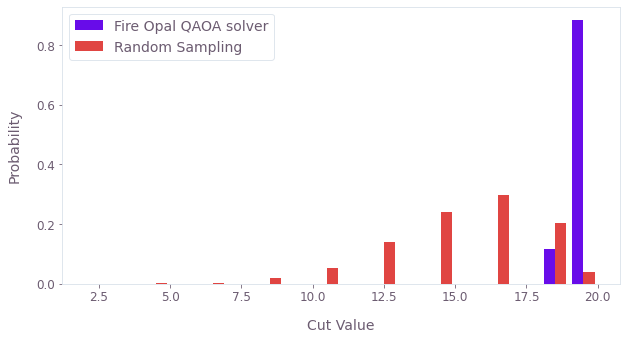

In [27]:
analyze_maxcut_results(
    distribution=unweighted_result["final_bitstring_distribution"],
    graph=G,
    optimal_cut_value=optimal_cut_value,
)